In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.autograd import grad
from torch import nn, optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import transforms as torch_transforms

In [2]:
import sys
sys.path.append("./../../")

from modules.dvae.model import DVAE
from modules.dvae.funcs import ng_quantize

from notebooks.utils import show

from datasets.mnist_loader import MNISTData

In [3]:
class Config:
    DEVICE                      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_labels                  = 10
    
    img_channels                = 1
    vocab_size                  = 32
    
    hidden_height               = 7
    hidden_width                = 7

    num_blocks                  = 10
    n_attn_heads                = 8
    hidden_dim                  = 256
    dropout_prob                = 0.1

    dvae_num_x2upsamples        = 2
    dvae_num_resids_downsample  = 3
    dvae_num_resids_bottleneck  = 4
    dvae_hidden_dim             = 256

    mnist_type                  = "classic"
    root_img_path               = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/MNIST/"
    
    load_dvae_path              = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/dvae_vocab32_mnist/"
    dvae_model_name             = "dvae_vocab32_mnist"
    
#     model_path                  = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/dtr_generator_v3/"
#     model_name                  = "dtr_generator_v3"
    
    NUM_EPOCHS                  = 30
    BATCH_SIZE                  = 512
    LR                          = 0.001
    LR_gamma                    = 0.1
    step_LR_milestones          = [5, 15, 25]


CONFIG = Config()

In [4]:
data_source = MNISTData(
    img_type=CONFIG.mnist_type,
    root_path=CONFIG.root_img_path,
    batch_size=CONFIG.BATCH_SIZE)
train_loader = data_source.get_train_loader()

In [5]:
class TrEncoderBlock(nn.Module):
    def __init__(self, n_features, n_attn_heads, n_hidden=64, dropout_prob=0.1):
        super(TrEncoderBlock, self).__init__()

        self.attn = nn.MultiheadAttention(n_features, n_attn_heads)
        self.ln1 = nn.LayerNorm(n_features)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.mlp = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.Dropout(dropout_prob),
            nn.GELU(),
            nn.Linear(n_hidden, n_features)
        )
        self.ln2 = nn.LayerNorm(n_features)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x, pad_mask=None, attn_mask=None):
        xn = self.ln1(x)
        dx, _ = self.attn(query=xn, key=xn, value=xn, 
                          key_padding_mask=pad_mask, 
                          attn_mask=attn_mask)
        x = x + self.dropout1(dx)
        
        xn = self.ln2(x)
        dx = self.mlp(xn)
        x = x + self.dropout2(dx)
        
        return x

In [23]:
class Generator(nn.Module):
    def __init__(self,
                 hidden_width,
                 hidden_height,
                 embedding_dim,
                 num_blocks,
                 hidden_dim,
                 n_attn_heads,
                 dropout_prob):
        super(Generator, self).__init__()

        self.hidden_width = hidden_width
        self.hidden_height = hidden_height
        self.embedding_dim = embedding_dim
        
        seq_len_img = hidden_width * hidden_height
        seq_len_all = hidden_width * hidden_height + 1
        
        self.img_tokens = nn.Parameter(torch.randn(seq_len_img, 1, embedding_dim))
        self.pe = nn.Parameter(torch.randn(seq_len_all, 1, embedding_dim))
        
        self.tr_blocks = nn.ModuleList([
            TrEncoderBlock(
                n_features=embedding_dim,
                n_attn_heads=n_attn_heads,
                n_hidden=hidden_dim,
                dropout_prob=dropout_prob)
            for _ in range(num_blocks)
        ])
        
        self.proj_out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, noise):
        
        _, b, emb = noise.size()
        img_tokens = self.img_tokens.repeat(1, b, 1)
        
        x = torch.cat([noise, img_tokens], dim=0)
        x = x + self.pe
        
        for i, block in enumerate(self.tr_blocks):
            x = block(x)
        
        x = self.proj_out(x)
        return x
    
    def save_model(self, root_path, model_name):
        if not os.path.exists(root_path):
            os.makedirs(root_path)
        path = os.path.join(root_path, model_name + ".pth")
        torch.save(self.state_dict(), path)
    
    def load_model(self, root_path, model_name, map_location=torch.device('cpu')):
        path = os.path.join(root_path, model_name + ".pth")
        self.load_state_dict(torch.load(path, map_location=map_location))

In [49]:
class Discriminator(nn.Module):
    def __init__(self,
                 embedding_dim,
                 hidden_height,
                 hidden_width,
                 num_blocks,
                 n_attn_heads,
                 hidden_dim,
                 dropout_prob):
        super(Discriminator, self).__init__()
        n_classes = 1
        
        num_latent_positions = hidden_height * hidden_width + 1
        self.pe = nn.Parameter(torch.randn(num_latent_positions, 1, embedding_dim))
        
        self.lin_proj = nn.Linear(embedding_dim, embedding_dim)
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        self.tr_encoder_blocks = nn.ModuleList([
            TrEncoderBlock(n_features=embedding_dim,
                           n_attn_heads=n_attn_heads,
                           n_hidden=hidden_dim,
                           dropout_prob=dropout_prob)
            for _ in range(num_blocks)
        ])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, n_classes),
        )

    def forward(self, x):
        x = self.lin_proj(x)
        cls_tokens = self.cls_token.expand(-1, b, -1)
        x = torch.cat((cls_tokens, x), dim=0)
        x += self.pe

        for i, block in enumerate(self.tr_encoder_blocks):
            x = block(x)

        #cls_input = x.mean(dim=0)
        cls_input = x[0, :, :]
            
        cls = self.mlp_head(cls_input).squeeze()

        return torch.sigmoid(cls)

In [50]:
dvae = DVAE(
    in_channels=CONFIG.img_channels,
    vocab_size=CONFIG.vocab_size,
    num_x2downsamples=CONFIG.dvae_num_x2upsamples,
    num_resids_downsample=CONFIG.dvae_num_resids_downsample,
    num_resids_bottleneck=CONFIG.dvae_num_resids_bottleneck,
    hidden_dim=CONFIG.dvae_hidden_dim)

G = Generator(
    embedding_dim=CONFIG.vocab_size,
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    num_blocks=CONFIG.num_blocks,
    n_attn_heads=CONFIG.n_attn_heads,
    hidden_dim=CONFIG.hidden_dim,
    dropout_prob=CONFIG.dropout_prob)

D = Discriminator(
    embedding_dim=CONFIG.vocab_size,
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    num_blocks=CONFIG.num_blocks,
    n_attn_heads=CONFIG.n_attn_heads,
    hidden_dim=CONFIG.hidden_dim,
    dropout_prob=CONFIG.dropout_prob)

optimizer_G = optim.Adam(G.parameters(), lr=CONFIG.LR)
optimizer_D = optim.Adam(D.parameters(), lr=CONFIG.LR)

# lr_scheduler = MultiStepLR(optimizer_G, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)

In [51]:
dvae.eval()
G.train()
D.train()

dvae.load_model(
    root_path=CONFIG.load_dvae_path,
    model_name=CONFIG.dvae_model_name)

# G.load_model(
#     root_path=CONFIG.model_path,
#     model_name=CONFIG.model_name)

dvae.to(CONFIG.DEVICE)
G.to(CONFIG.DEVICE)
D.to(CONFIG.DEVICE)

pass

In [52]:
print("Device in use: {}".format(CONFIG.DEVICE))

criteriation = nn.CrossEntropyLoss()

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for img, label in train_loader:
        #label = label.to(CONFIG.DEVICE)
        img = img.to(CONFIG.DEVICE)

        with torch.no_grad():
            latent = dvae.sm_encode(img)
            latent += (1 - latent) * torch.rand(latent.size(), device=latent.device) * 0.6
            latent = F.softmax(latent, dim=1)
            b, emb, h, w = latent.size()
            real = latent.view(b, emb, -1).permute(2, 0, 1)

        current_batch_dim = real.size(1)
        labels_real = torch.full((current_batch_dim,), 1.0, device=CONFIG.DEVICE)
        labels_fake = torch.full((current_batch_dim,), 0.0, device=CONFIG.DEVICE)

        noise = torch.randn(1, b, emb, device=CONFIG.DEVICE)
        
        ############################
        ### Update Discriminator ###
        ############################
        D.zero_grad()
        fake = G(noise=noise)
        fake = fake[1:, :, :]

        labels_D_real = D(real)
        d_loss_real = F.binary_cross_entropy(labels_D_real, labels_real)

        labels_D_fake = D(fake.detach())
        d_loss_fake = F.binary_cross_entropy(labels_D_fake, labels_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        avg_label_D_real = labels_D_real.mean().item()
        avg_label_D_fake = labels_D_fake.mean().item()

        ############################
        ##### Update Generator #####
        ############################
        G.zero_grad()

        labels_D_fake = D(fake)

        g_loss = F.binary_cross_entropy(labels_D_fake, labels_real)
        g_loss.backward()
        optimizer_G.step()

        if iteration % 55 == 0:
            print("Epoch: {} Iter: {} G_Loss: {} D_Loss: {}".format(
                epoch,
                iteration,
                round(g_loss.item(), 5),
                round(d_loss.item(), 5)
            ))
        
        iteration += 1
    
    #lr_scheduler.step()
    

Device in use: cuda
Epoch: 0 Iter: 0 G_Loss: 0.39816 D_Loss: 1.47568
Epoch: 0 Iter: 55 G_Loss: 2.10737 D_Loss: 0.37854
Epoch: 0 Iter: 110 G_Loss: 3.80476 D_Loss: 0.0532


KeyboardInterrupt: 

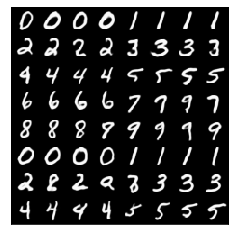

In [20]:
hidden_width = CONFIG.hidden_width
hidden_height = CONFIG.hidden_height
seq_len = hidden_width * hidden_height
embedding_dim = CONFIG.vocab_size
batch_size = 64

samples = torch.zeros(seq_len + 1, batch_size, embedding_dim).to(CONFIG.DEVICE)

sample_labels = torch.LongTensor([
    0, 0, 0, 0, 1, 1, 1, 1,
    2, 2, 2, 2, 3, 3, 3, 3,
    4, 4, 4, 4, 5, 5, 5, 5,
    6, 6, 6, 6, 7, 7, 7, 7,
    8, 8, 8, 8, 9, 9, 9, 9,
    0, 0, 0, 0, 1, 1, 1, 1,
    2, 2, 2, 2, 3, 3, 3, 3,
    4, 4, 4, 4, 5, 5, 5, 5
]).to(CONFIG.DEVICE)

sample_noise = torch.randn(1, batch_size, CONFIG.vocab_size, device=CONFIG.DEVICE)

with torch.no_grad():
    for i in range(seq_len):
        out, cross_attn_maps = G(samples[:-1,:,:], sample_labels, sample_noise)
        
        z = ng_quantize(out, dim=-1)
        one_hot_sample = z[i,:,:]

        samples[i+1, :, :] = one_hot_sample

latent_x = samples[1:, :, :].view(hidden_height, hidden_width, batch_size, embedding_dim).permute(2, 3, 0, 1)

with torch.no_grad():
    gen_img = dvae.decode(latent_x)

show(gen_img)

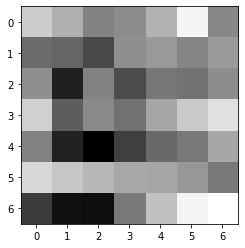

In [69]:
block_map = cross_attn_maps[-1]
token_block_map = block_map[12, :, 1].view(hidden_height, hidden_width)

pltheatmap = token_block_map.detach().cpu().numpy()

plt.imshow(pltheatmap, cmap='binary')
plt.show()

In [2]:
!nvidia-smi

Wed May 12 18:22:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:02:00.0 Off |                  Off |
| 39%   63C    P0   161W / 180W |  15729MiB / 16277MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------